In [1]:
from google.colab import drive
import time
import torch
import itertools
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import os
from os import path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import matplotlib.patches as patches
from collections import Counter


drive.mount("/content/drive", force_remount=True) #Se monta Drive en pc de colab
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #Se programa para usar GPU


Mounted at /content/drive


In [6]:
cd "/content/drive/MyDrive/Deep Learning/data"

/content/drive/MyDrive/Deep Learning/data


In [7]:
cp data.tar '/content/sample_data' #Se copia de drive a Colab el dataset

In [8]:
cd "/content/sample_data"

/content/sample_data


In [10]:
!tar -xvf 'data.tar' #Se descomprimen los datos

Se truncaron las últimas líneas 5000 del resultado de transmisión.
VOCdevkit/VOC2007/JPEGImages/001732.jpg
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC

In [11]:
!rm data.tar # Se borran datos luego de comprimidos

In [12]:
from torchvision import datasets
#http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar link para descarga de dataset
full_dataset = datasets.VOCDetection('/content/sample_data', year='2007', image_set='train',download=False)
test_dataset = datasets.VOCDetection('/content/sample_data', year='2007', image_set='val',download=False)

In [13]:
#Clases de VOC2007 to id numerico
class_to_id = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19}
#Id numerico to Clases de VOC2007
id_to_class = {i:c for c, i in class_to_id.items()}

In [14]:
#Función para ajuste del dataset de imágenes de VOC2007
def funcion_ajuste_dataset(batch, reshape_size=448,S=7, B=2, C=20): #Función para ajuste del dataset 448
    transormation = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)), #Se fija el tamaño de las imagenes en 224x224 para evitar variaciones en las input a alas redes
      transforms.ToTensor(), #Se transforma a tensor
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      ])
    
    batch_size = len(batch)
    
    #Se prepara batch de imagenes
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size) #Creo tensor de imagenes (B,3,448,448)

  
    #Se prepara batch de recuadros
    box_batch = torch.Tensor(batch_size,S,S,C+5*B).fill_(0)#Creo tensor de recuadros (B,7,7,30)
    

    for b_i in range(batch_size): #Se recorre el batch
      img, ann = batch[b_i] #Se obtiene Imagen,Annotation
      w_img=int(img.size[0]) # Image width
      h_img=int(img.size[1]) # Image height

      img_batch[b_i] = transormation(img) #Proceso la imagen con la transformacion
      
      all_bbox = ann['annotation']['object'] #Obtengo todos los recuadros disponibles
      if type(all_bbox) == dict: # inconsistency in the annotation file
        all_bbox = [all_bbox]
      for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox'] #Obtengo parametros del recuadro x1 y1 x2 y2
        obj_cls = one_bbox['name'] #Obtengo la clase del objeto del rectangulo

        
        x = (int(bbox['xmax']) + int(bbox['xmin']))/(2*w_img) #Busco centro x del recuadro
        y = (int(bbox['ymax']) + int(bbox['ymin']))/(2*h_img) #Busco centro y del recuadro
        w = (int(bbox['xmax'])-int(bbox['xmin']))/w_img #Calculo ancho del recuadro
        h = (int(bbox['ymax'])-int(bbox['ymin']))/h_img #Calculo alto del recuadro
        class_label = class_to_id[obj_cls] #Paso a numero la clase del objeto

        i, j = int(S * y), int(S * x) #Obtengo pos de esq sup izquierda del cuadrante q contiene el centro
        x_cell, y_cell = S * x - j, S * y - i #Obtengo x e y relativo a esq sup izq del cuadrante correspondiente
        width_cell = w * S #Obtengo el ancho en relacion al ancho de la celda
        height_cell = h * S #Obtengo el alto en relación al alto de la celda

        if box_batch[b_i][i, j, 20] == 0: #Objeto no presente en ese cuadrante
          # Set that there exists an object
          box_batch[b_i][i, j, 20] = 1
          # Box coordinates
          box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
          #box_coordinates = torch.tensor([x, y, w, h])
          box_batch[b_i][i, j, 21:25] = box_coordinates
          # Set one hot encoding for class_label
          box_batch[b_i][i, j, class_label] = 1 #Pongo 1 en clase correspondiente

    return img_batch, box_batch

In [15]:
full_dataset = torch.utils.data.Subset(full_dataset, torch.arange(0, 2500)) # Se hace subset de 2500 imagenes

train_size = int(0.8 * len(full_dataset)) #Se divide dataset de entrenamiento en 80% Entrenamiento 
valid_size = len(full_dataset) - train_size #Se divide dataset de entrenamiento en 20% de validación

In [16]:
#Configuraciones del modelo Globales
BATCH_SIZE = 32 #Numero de batches para entrenamiento

#### Creación de Dataloaders

In [17]:
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset,[train_size, valid_size]) #Dataset de validación y entrenamiento

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True, pin_memory=True,num_workers=4,collate_fn=funcion_ajuste_dataset) 
val_loader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True, pin_memory=True,num_workers=4,collate_fn=funcion_ajuste_dataset) 

test_loader = DataLoader(test_dataset,batch_size=int(BATCH_SIZE/BATCH_SIZE),shuffle=True, pin_memory=True,num_workers=4,collate_fn=funcion_ajuste_dataset) 

El Dataloader devuelve batches de datos.

La primera salida del Dataloader es un Tensor de imagen con la forma (B,3,224,224) siendo B la cantidad de imagenes del batch.

La segunda salida corresponde a los recuados en la imagen del tipo (B,N,5), para cada una de las B imágenes del dataset se obtienen los N recuadros de 5 parámetros cada uno.Los parámetros son [x_sI,y_sI,x_iD,y_iD,clase]


 #### Función de transformación de coordenadas

##### Función de visualización

In [18]:
def data_visualizer(img, bbox=None, pred=None ,S=7, B=2, C=20):
  img_copy = np.array(img.permute(1, 2, 0))#.astype('uint8')
  width,height, _= img_copy.shape
  img_copy = cv2.UMat(img_copy).get()
  for i in range(S):
    for j in range(S):
      if bbox!=None and bbox[i][j][20]: #Veo presencia de objeto
        box = bbox[i][j][21:25].tolist()
        obj_class = bbox[i][j][0:19].tolist()

        upper_left_x = float(j*width/S) + float(box[0]*width/S) - float(box[2]*width/(2*S))
        upper_left_y = float(i*height/S) + float(box[1]*height/S) - float(box[3]*height/(2*S))
    
        bottom_left_x = float(j*width/S) + float(box[0]*width/S) + float(box[2]*width/(2*S))
        bottom_left_y = float(i*height/S) + float(box[1]*height/S) + float(box[3]*height/(2*S))

        cv2.rectangle(img_copy, (int(upper_left_x),int(upper_left_y)), (int(bottom_left_x),int(bottom_left_y)), (0, 255, 0), 2)
        obj_cls = id_to_class[np.argmax(obj_class)]
        cv2.putText(img_copy, '%s' % (obj_cls),(int(upper_left_x),int(upper_left_y)),cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 255, 0), thickness=2)

      if pred!=None and pred[i][j][20]>0.50: #Veo presencia de objeto
        box = pred[i][j][21:25].tolist()
        obj_class = pred[i][j][0:19].tolist()

        upper_left_x = float(j*width/S) + float(box[0]*width/S) - float(box[2]*width/(2*S))
        upper_left_y = float(i*height/S) + float(box[1]*height/S) - float(box[3]*height/(2*S))
    
        bottom_left_x = float(j*width/S) + float(box[0]*width/S) + float(box[2]*width/(2*S))
        bottom_left_y = float(i*height/S) + float(box[1]*height/S) + float(box[3]*height/(2*S))

        cv2.rectangle(img_copy, (int(upper_left_x),int(upper_left_y)), (int(bottom_left_x),int(bottom_left_y)), (255, 0, 0), int(pred[i][j][20]))
        obj_cls = id_to_class[np.argmax(obj_class)]
        cv2.putText(img_copy, '%s' % (obj_cls),(int(upper_left_x),int(upper_left_y)),cv2.FONT_HERSHEY_PLAIN, 2.0, (255, 0, 0), thickness=2)

      if pred!=None and pred[i][j][25]>0.50: #Veo presencia de objeto
        box = pred[i][j][26:30].tolist()
        obj_class = pred[i][j][0:19].tolist()

        upper_left_x = float(j*width/S) + float(box[0]*width/S) - float(box[2]*width/(2*S))
        upper_left_y = float(i*height/S) + float(box[1]*height/S) - float(box[3]*height/(2*S))
    
        bottom_left_x = float(j*width/S) + float(box[0]*width/S) + float(box[2]*width/(2*S))
        bottom_left_y = float(i*height/S) + float(box[1]*height/S) + float(box[3]*height/(2*S))

        cv2.rectangle(img_copy, (int(upper_left_x),int(upper_left_y)), (int(bottom_left_x),int(bottom_left_y)), (255, 0, 0), int(pred[i][j][25]))
        obj_cls = id_to_class[np.argmax(obj_class)]
        cv2.putText(img_copy, '%s' % (obj_cls),(int(upper_left_x),int(upper_left_y)),cv2.FONT_HERSHEY_PLAIN, 2.0, (255, 0, 0), thickness=2)
  
  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

#### Ejemplo de visualización

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


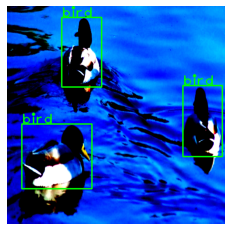

In [19]:
# visualize GT boxes
#for i in range(len(img_list)):
  #valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])#Se fija los recuadros q no tienen -1 en sis datos
muestra_train_loader = enumerate(train_loader)
batch_idx, (imagen_data, data_targets) = next(muestra_train_loader)
data_visualizer(imagen_data[0], data_targets[0])#Toma los primeros recuadros

#### Construcción de la red (Arquitectura)

In [20]:
from google.colab import files
from IPython.display import Image
#upload_files = files.upload()
#Image("YOLO.png", width=1000)

In [21]:
class Yolo(nn.Module):
  def __init__(self,in_channels, verbose=False):
    super(Yolo, self).__init__()
    self.verbose = verbose
    self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # box 1
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # box 2
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1, bias=False)
    
    #box 3
    self.conv3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, bias=False)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, bias= False)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False)
    
    #box 4
    self.conv7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, bias=False)
    self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias= False)
    self.conv9 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, bias= False)
    self.conv10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias= False)
    self.conv11 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, bias= False)
    self.conv12 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias= False)
    self.conv13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, bias= False)
    self.conv14 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False)
    # hasta aca el x 4
    self.conv15 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, bias=False)
    self.conv16 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, bias=False)

    # # box 5
    self.conv17 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, bias=False)
    self.conv18 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, bias= False)
    self.conv19 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, bias= False)
    self.conv20 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, bias=False)
    # # hasta aca el x 2
    self.conv21 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False)
    self.conv22 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2 , padding=1, bias=False)
    
    # box 6
    self.conv23 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias= False)
    self.conv24 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False)

    # box 7 9216
    S = 7
    B = 2
    C = 20
    self.fc1 = nn.Linear(in_features=(1024 * S*S), out_features=4096)
    self.fc2 = nn.Linear(in_features=4096, out_features=S*S*(C+B*5))
    self.relu = nn.LeakyReLU(0.1)
    self.drop = nn.Dropout(0.2)
                        
  def forward(self, input):
    # box 1
    out = self.relu(self.conv1(input))
    out = self.maxpooling(out)
   
    # box 2
    out = self.relu(self.conv2(out))
    out = self.maxpooling(out)
    
    # box 3 (3 a la 6) 
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv4(out))
    out = self.relu(self.conv5(out))
    out = self.relu(self.conv6(out))
    out = self.maxpooling(out)

    # box 4 (7 a la 16)
    out = self.relu(self.conv7(out))
    out = self.relu(self.conv8(out))
    out = self.relu(self.conv9(out))
    out = self.relu(self.conv10(out))
    out = self.relu(self.conv11(out))
    out = self.relu(self.conv12(out))
    out = self.relu(self.conv13(out))
    out = self.relu(self.conv14(out))
    # hasta aca el x 4
    out = self.relu(self.conv15(out))
    out = self.relu(self.conv16(out))
    out = self.maxpooling(out)

    # # box 5 (17 a 22)
    out = self.relu(self.conv17(out))
    out = self.relu(self.conv18(out))
    out = self.relu(self.conv19(out))
    out = self.relu(self.conv20(out))
    # # hasta aca el x 2
    out = self.relu(self.conv21(out))
    out = self.relu(self.conv22(out))
    
    # box 6 (23 a 24)
    out = self.relu(self.conv23(out))
    out = self.relu(self.conv24(out))
    
    # box 7
    out = out.flatten(1)
    #out = self.drop(out)
    out = self.relu(self.fc1(out))
    out = self.fc2(out)
    
    return out 


#### Entrenamiento

In [22]:
def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    # Codigo para una sola epoch de entrenamiento.
    epoch_loss = 0.0
    #all_labels = []
    #all_predictions = []

    #for img_batch, box_batch, w_batch, h_batch,img_id_list in loader:
    for img_batch, box_batch in loader:
      #all_labels.extend(labels.numpy())
      
      optim.zero_grad()
      
      predictions = training_model(img_batch.to(device))
      #all_predictions.extend(torch.argmax(predictions,dim=1).cpu().numpy())
      
      loss =criterion(predictions,box_batch.to(device))
      loss.backward()
      optim.step()

      epoch_loss+=loss.item()
      #return epoch_loss/len(loader),accuracy_score(all_labels,all_predictions)*100
    return epoch_loss/len(loader), 1

def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    # Codigo para una sola epoch de entrenamiento.
    epoch_loss = 0.0
    #all_labels = []
    #all_predictions = []

    with torch.no_grad():
      # Codigo para una epoch de evaluacion (validation o test).
        for img_batch, box_batch in loader:
        #for img_batch, box_batch, w_batch, h_batch,img_id_list in loader:
          #all_labels.extend(labels.numpy())

          predictions = val_model(img_batch.to(device))
          #all_predictions.extend(torch.argmax(predictions,dim=1).cpu().numpy())
          
          loss =criterion(predictions,box_batch.to(device))

          epoch_loss+=loss.item()

    #return epoch_loss/len(loader),accuracy_score(all_labels,all_predictions)*100
    return epoch_loss/len(loader), 1


def test_epoch(val_model, loader, criterion):
    val_model.eval()
    # Codigo para una sola epoch de entrenamiento.
    epoch_loss = 0.0
    #all_labels = []
    #all_predictions = []

    with torch.no_grad():
      # Codigo para una epoch de evaluacion (validation o test).
        #for img_batch, box_batch, w_batch, h_batch,img_id_list in loader:
        for img_batch, box_batch in loader:
          #all_labels.extend(labels.numpy())

          predictions = val_model(img_batch.to(device))
          #all_predictions.extend(torch.argmax(predictions,dim=1).cpu().numpy())

          
          loss =criterion(predictions,box_batch.to(device))

          epoch_loss+=loss.item()

    #return epoch_loss/len(loader),accuracy_score(all_labels,all_predictions)*100,f1_score(all_labels, all_predictions, average='macro'),precision_score(all_labels, all_predictions, average='macro'),recall_score(all_labels, all_predictions, average='macro')  
    return epoch_loss/len(loader), 1  


In [23]:
def train_model(modelo, train_loader, test_loader, criterion, optim, number_epochs):
  train_history = []
  test_history = []
  accuracy_history_train =[]
  accuracy_history = []

  for epoch in range(number_epochs):
      start_time = time.time()

      train_loss, train_acc = train_epoch(modelo, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      accuracy_history_train.append(train_acc)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

      start_time = time.time()
      test_loss, acc = validation_epoch(modelo, test_loader, criterion)
      test_history.append(test_loss)
      accuracy_history.append(acc)
      print("Test epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, test_loss, acc, time.time() - start_time))

  fig = plt.figure()
  plt.axis([0,number_epochs,0,train_history[0]])
  plt.plot(train_history, label='train loss')
  plt.plot(test_history, label='val loss')
  plt.legend()

 
  fig2 = plt.figure()
  plt.axis([0,number_epochs,0,100])
  plt.plot(accuracy_history_train, label='train accuracy %')
  plt.plot(accuracy_history, label='val accuracy %')
  plt.legend()

  #return train_history,test_history,accuracy_history

In [24]:
def test_model(modelo, test_loader, criterion):
  test_history = []
  accuracy_history = []

  start_time = time.time()
  test_loss, acc, f1, precision , recall = test_epoch(modelo, test_loader, criterion)
  print("Test Metrics{} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f} | Precision {:.2f} | Recall {:.2f} | Time {:.2f} seconds"
            .format(1, test_loss, acc , f1 , precision , recall , time.time() - start_time))
  return test_loss, acc, f1, precision , recall

##### Función de costo
###### Intersection Over Union - IOU

In [25]:
def iou(boxes_predictions, boxes_labels, boxes_format = "midpoint"):
    """Para universalizar, se implementa de forma que la caja puede venir dada por
    los vértices, ancho y alto o puede venir dada por su punto medio ancho y alto"""

    if boxes_format == "midpoint": 
        box1_x1 = boxes_predictions[..., 0:1] - boxes_predictions[..., 2:3] / 2
        box1_y1 = boxes_predictions[..., 1:2] - boxes_predictions[..., 3:4] / 2
        box1_x2 = boxes_predictions[..., 0:1] + boxes_predictions[..., 2:3] / 2
        box1_y2 = boxes_predictions[..., 1:2] + boxes_predictions[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)


    """Hacemos clamp para que si se diera el caso borde en que no se intersectan,
    al menos uno de los dos va a ser 0"""
    inter = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    area_box1 = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    area_box2 = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return inter / (area_box1 + area_box2 - inter + 1e-6) #Se agrega 1e-6 para balance numérico

In [26]:
    class loss_function(nn.Module):
        def __init__(self, S = 7, B = 2, C = 20):
            super(loss_function, self).__init__()
            """Se hace reduction = "sum" a la salida porque en el paper no se promedia el error cuadrático 
            medio"""
            self.mse = nn.MSELoss(reduction = "mean")
            self.cross = nn.CrossEntropyLoss(reduction = "mean")
            self.S = S
            self.B = B
            self.C = C
            self.lambda_noobj = 0.5
            self.lambda_coord = 5
        
        def forward(self, predictions, target):
            """Hay que asegurarse que las predicciones sean de S*S*30"""
            predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

            """Del 0 al 19 son las probabilidades de clase. 20 es para el score de clase.
            Del 21 al 25 son las coordenadas de la bounding box. El target conserva los ´
            índices en el slicing porque el target es uno solo"""
            iou_box1 = iou(predictions[..., 21:25], target[..., 21:25])
            iou_box2 = iou(predictions[..., 26:30], target[..., 21:25])
            """Concatenamos a lo largo de la dimension 0"""
            ious = torch.cat([iou_box1.unsqueeze(0), iou_box2.unsqueeze(0)], dim = 0)
            """torch.max devuelve una tupla con los valores máximos y el argmax del tensor
            Tomamos el máximo para determinar cuál fue la responsable de la celda como dice el paper"""
            iou_maximos, best_box = torch.max(ious, dim = 0)
            """Función identidad del paper para ver si existe objeto en la celda"""
            existe_caja = target[..., 20].unsqueeze(3)

            #Para las coordenadas de las cajas
            """"best_box es 0 o 1 dependiendo de cuál bounding box fue
            la correcta. Computamos respecto a la existencia de una caja porque
            solamente queremos computar la pérdida si efectivamente hay un objeto
            en la celda
            """
            box_predictions = existe_caja * (
                (
                    best_box * predictions[..., 26:30] 
                    + (1 - best_box) * predictions[..., 21:25]
                )

            )
            #Computamos existencia para los targets
            box_targets = existe_caja * target[..., 21:25]

            """Tomamos la raíz cuadrada para el ancho y el alto. Como al principio las predicciones van a ser negativas, 
            tomamos el valor absoluto de las mismas para no tener errores al hacer la raíz.
            Adicionalmente, cuando hacemos el valor absoluto, nos aseguramos que el signo del gradiente sea correcto 
            haciendo sign al principio"""
            box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
                torch.abs(box_predictions[..., 2:4] + 1e-6)
            )

            #Los targets no serán negativos por lo tanto no es necesario abs
            box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
            
            """"Se hace flatten para pasar de (N, S, S, 4) a (N * S * S, 4) ya que
            es el formato en el que MSELoss espera recibir los datos"""
            box_loss = self.mse(
                torch.flatten(box_predictions, end_dim = -2), 
                torch.flatten(box_targets, end_dim = -2),
            )
            #Para la pérdida del objeto
            prediction_box = (
                best_box * predictions[..., 25:26] + (1 - best_box) * predictions[..., 20:21]
            )
            #(N * S * S, 1)
            loss_objeto = self.mse(
                torch.flatten(existe_caja * prediction_box), 
                torch.flatten(existe_caja * target[..., 20:21]),
            )
            """Para la pérdida cuando no hay objeto
            (N, S, S, 1) -> (N, S * S)
            Para el primero:"""
            loss_no_objeto = self.mse(
                torch.flatten((1 - existe_caja) * predictions[..., 20:21], start_dim = 1), 
                torch.flatten((1 - existe_caja) * target[..., 20:21], start_dim = 1)
            )
            #Para los siguientes
            loss_no_objeto += self.mse(
                torch.flatten((1 - existe_caja) * predictions[..., 25:26], start_dim = 1),
                torch.flatten((1 - existe_caja) * target[..., 20:21], start_dim = 1)
            )

            #Para la pérdida de clases
            class_loss = self.mse(
                torch.flatten(predictions[..., :20], end_dim = -2),
                torch.flatten(target[..., :20], end_dim=-2)
            )
            
            #print(torch.flatten(existe_caja * target[..., :20], end_dim = -2).shape)
            loss = (
                self.lambda_coord * box_loss + loss_objeto
                + self.lambda_noobj * loss_no_objeto 
                + class_loss
            )

            return loss

Training epoch 1 | Loss 0.358551 | Accuracy 1.00% | Time 45.83 seconds
Test epoch 1 | Loss 0.271350 | Accuracy 1.00% | Time 9.35 seconds
Training epoch 2 | Loss 0.237576 | Accuracy 1.00% | Time 44.62 seconds
Test epoch 2 | Loss 0.185119 | Accuracy 1.00% | Time 9.40 seconds
Training epoch 3 | Loss 0.138666 | Accuracy 1.00% | Time 44.72 seconds
Test epoch 3 | Loss 0.121057 | Accuracy 1.00% | Time 9.22 seconds
Training epoch 4 | Loss 0.140980 | Accuracy 1.00% | Time 44.37 seconds
Test epoch 4 | Loss 0.135323 | Accuracy 1.00% | Time 9.20 seconds
Training epoch 5 | Loss 0.108048 | Accuracy 1.00% | Time 44.72 seconds
Test epoch 5 | Loss 0.101935 | Accuracy 1.00% | Time 9.18 seconds
Training epoch 6 | Loss 0.090828 | Accuracy 1.00% | Time 44.44 seconds
Test epoch 6 | Loss 0.097931 | Accuracy 1.00% | Time 9.17 seconds
Training epoch 7 | Loss 0.089220 | Accuracy 1.00% | Time 44.30 seconds
Test epoch 7 | Loss 0.093834 | Accuracy 1.00% | Time 9.21 seconds
Training epoch 8 | Loss 0.087036 | Accura

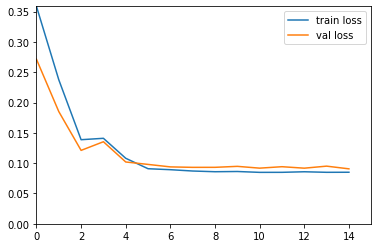

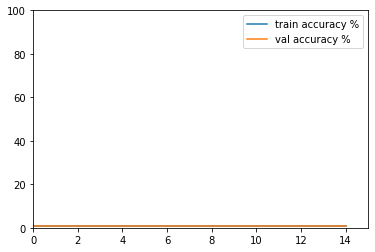

In [39]:
modelo = Yolo(3).to(device)
criterion = loss_function().to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0002)

train_model(modelo,train_loader,val_loader,criterion,optimizer, 15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


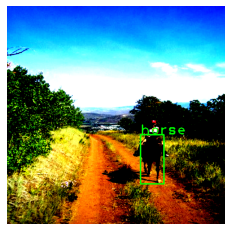

In [40]:
muestra_test_loader = enumerate(test_loader)
batch_idx, (imagen_data, data_targets) = next(muestra_test_loader)
predictions = modelo(imagen_data.to(device))

S=7
B=2
C=20

predictions = predictions.reshape(-1, S, S, C + B * 5)

data_visualizer(imagen_data[0], data_targets[0],predictions[0])#Toma los primeros recuadros